# Finding Jacobian
What is the change in Intensity for a partial change in any of the TMPs. In this notebook we find an analytical expression(Somewhat) and compare that to a numerical approach. We also look at the dependence of these derivatives on the rest of TMPs and the system itself!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from inverse_modelling_tfo.tools.name_decoder import decode_extended_filename
from ipywidgets import interact
import ipywidgets as widgets
from tfo_sensitivity.data import load_raw
from inverse_modelling_tfo.tools.s_based_intensity_datagen import MU_MAP_BASE1, MU_MAP_BASE2, get_mu_a
from tfo_sensitivity.calculate_intensity import generate_intensity, generate_intensity_column
from tfo_sensitivity.jacobian import calculate_jacobian
import seaborn as sns

plt.style.use('seaborn')

maternal_wall_thickness, uterus_thickness, wave_int = 20, 5, 1
raw_sim_data_path = load_raw(
    maternal_wall_thickness, uterus_thickness, wave_int)
raw_sim_data = pd.read_pickle(raw_sim_data_path)
# Create SDD column!
raw_sim_data['SDD'] = raw_sim_data['X'] - 100
all_sdd = raw_sim_data['SDD'].unique()

In [2]:
# plt.rcParams['figure.dpi'] = 150    # Smaller plot
plt.rcParams['figure.dpi'] = 700    # Paper-ready plots

PLOT_NORMALIZED = True  # Plot the Jacibian divided by Current Intensity (Similar to normalized derivative)
jacobian_type = 'norm_der' if PLOT_NORMALIZED else 'regular'

## Jacobian For saturation
From my derivations,
$$
\frac{\delta I}{\delta S} = -(\epsilon_{Hbo} - \epsilon_{HHb}) \times c \times \sum (L_i I_i)
$$

In [3]:
MATERNAL_Hb = 2.
MATERNAL_SAT = 1.0
FETAL_SAT = 0.225
FETAL_Hb = 0.9
DELTA = 0.00001

data_table = pd.DataFrame(columns=['Saturation', 'Derivative', 'SDD', 'Type'])
all_c = np.arange(0.1, 1.5, 0.1)
all_fetal_sat = np.arange(0.1, 0.65, 0.2)
base_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2

modified_mu_map = base_mu_map.copy()
modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
modified_mu_map[4] = get_mu_a(FETAL_SAT, FETAL_Hb, wave_int)

for sdd_index in np.arange(2, 20, 2):
    SDD = all_sdd[sdd_index]
    filtered_photon_data  = (raw_sim_data[raw_sim_data["SDD"] == SDD]).copy()
    for fs in all_fetal_sat:
    # for ms in [1.0, 2.0, 3.0, 4.0]:
        fs = round(fs, 2)
        dI = calculate_jacobian(jacobian_type, raw_sim_data, sdd_index, base_mu_map, DELTA, 'FS', all_sdd, MATERNAL_Hb, MATERNAL_SAT, FETAL_Hb, fs, wave_int)
        
        # Analytical Expression
        eps_hbo = get_mu_a(1.0, 1, wave_int)
        eps_hhb = get_mu_a(0.0, 1, wave_int)
        modified_mu_map[4] = get_mu_a(fs, FETAL_Hb, wave_int)
        I = generate_intensity_column(filtered_photon_data, modified_mu_map, sdd_index)
        L = filtered_photon_data["L4 ppath"].to_numpy()
        analytical_term = - (eps_hbo - eps_hhb) * FETAL_Hb * np.dot(L, I)
        if PLOT_NORMALIZED:
            analytical_term /= np.sum(I) 
        
        # Adding to Table
        new_row1 = {'Saturation' : fs, 'Derivative': dI, 'SDD': all_sdd[sdd_index], 'Type': 'Numerical'}
        new_row2 = {'Saturation' : fs, 'Derivative': analytical_term, 'SDD': all_sdd[sdd_index], 'Type': 'Analytical'}
        data_table.loc[len(data_table)] = new_row1
        data_table.loc[len(data_table)] = new_row2

Text(0, 0.5, '$\\frac{\\partial I}{\\partial S_f} $')

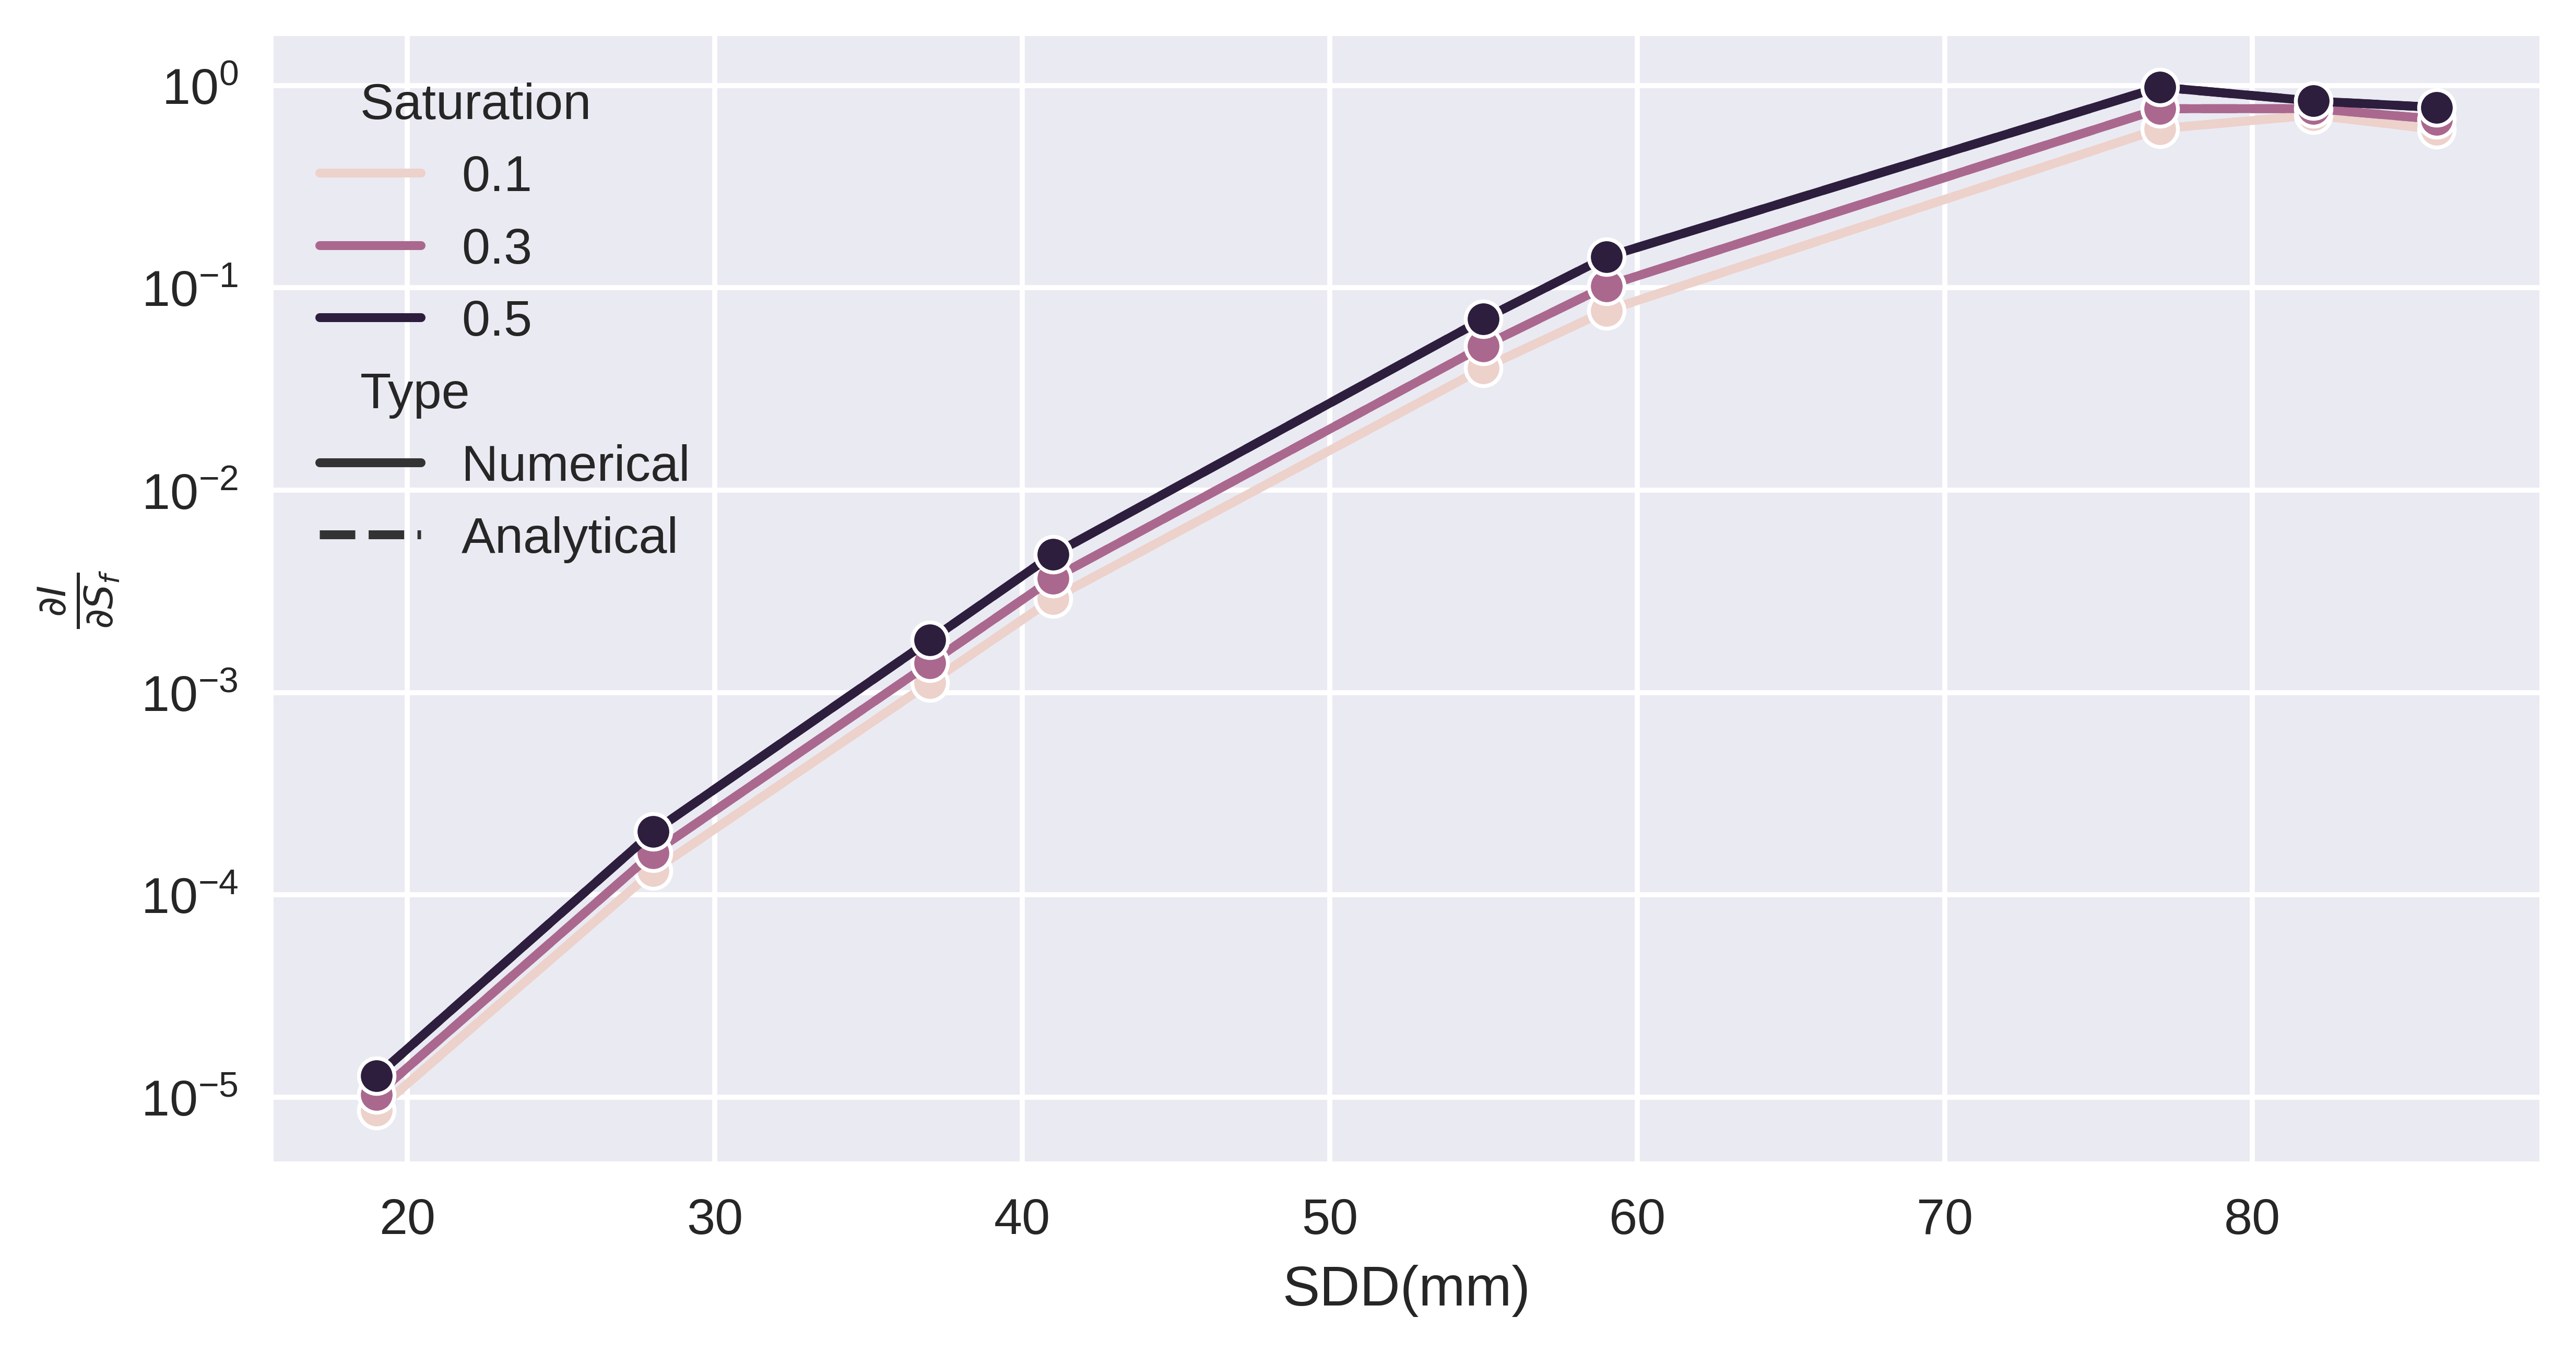

In [4]:
plt.figure(figsize=(8, 4))
plot = sns.lineplot(data=data_table, x='SDD', y='Derivative', hue='Saturation', style='Type', marker='o')
plt.yscale('log')
plt.xlabel('SDD(mm)')
plt.ylabel(r'$\frac{\partial I}{\partial S_f} $')

__Remarks__ : This plot is done for a constant c. The partial derivative of the first term(The $\frac{\partial log(|A(c)|)}{\partial c}$) does not have any term related to SDD. According to that part, the derivative is constant. But clearly, the derivative is not. So this would be the effect of the second term. 

In [5]:
MATERNAL_Hb = 2.
MATERNAL_SAT = 1.0
FETAL_SAT = 0.225
FETAL_Hb = 0.9
DELTA = 0.00001

data_table = pd.DataFrame(columns=['Concentration (g/dL)', 'Derivative', 'SDD', 'Type'])
all_c = np.arange(1.0, 4.0, 0.5)
all_fetal_sat = np.arange(0.1, 0.65, 0.2)
base_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2

modified_mu_map = base_mu_map.copy()
modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
modified_mu_map[4] = get_mu_a(FETAL_SAT, FETAL_Hb, wave_int)

for sdd_index in np.arange(2, 20, 2):
    SDD = all_sdd[sdd_index]
    filtered_photon_data  = (raw_sim_data[raw_sim_data["SDD"] == SDD]).copy()
    for fc in all_c:
    # for ms in [1.0, 2.0, 3.0, 4.0]:
        dI = calculate_jacobian(jacobian_type, raw_sim_data, sdd_index, base_mu_map, DELTA, 'FS', all_sdd, MATERNAL_Hb, MATERNAL_SAT, fc, FETAL_SAT, wave_int)
        
        # Analytical Expression
        eps_hbo = get_mu_a(1.0, 1, wave_int)
        eps_hhb = get_mu_a(0.0, 1, wave_int)
        modified_mu_map[4] = get_mu_a(FETAL_SAT, fc, wave_int)
        I = generate_intensity_column(filtered_photon_data, modified_mu_map, sdd_index)
        L = filtered_photon_data["L4 ppath"].to_numpy()
        analytical_term = -(eps_hbo - eps_hhb) * fc * np.dot(L, I)
        if PLOT_NORMALIZED:
            analytical_term /= np.sum(I) 
        
        # Adding to Table
        new_row1 = {'Concentration (g/dL)' : fc, 'Derivative': dI, 'SDD': all_sdd[sdd_index], 'Type': 'Numerical'}
        new_row2 = {'Concentration (g/dL)' : fc, 'Derivative': analytical_term, 'SDD': all_sdd[sdd_index], 'Type': 'Analytical'}
        data_table.loc[len(data_table)] = new_row1
        data_table.loc[len(data_table)] = new_row2

Text(0, 0.5, '$\\frac{\\partial I}{\\partial S_f} $')

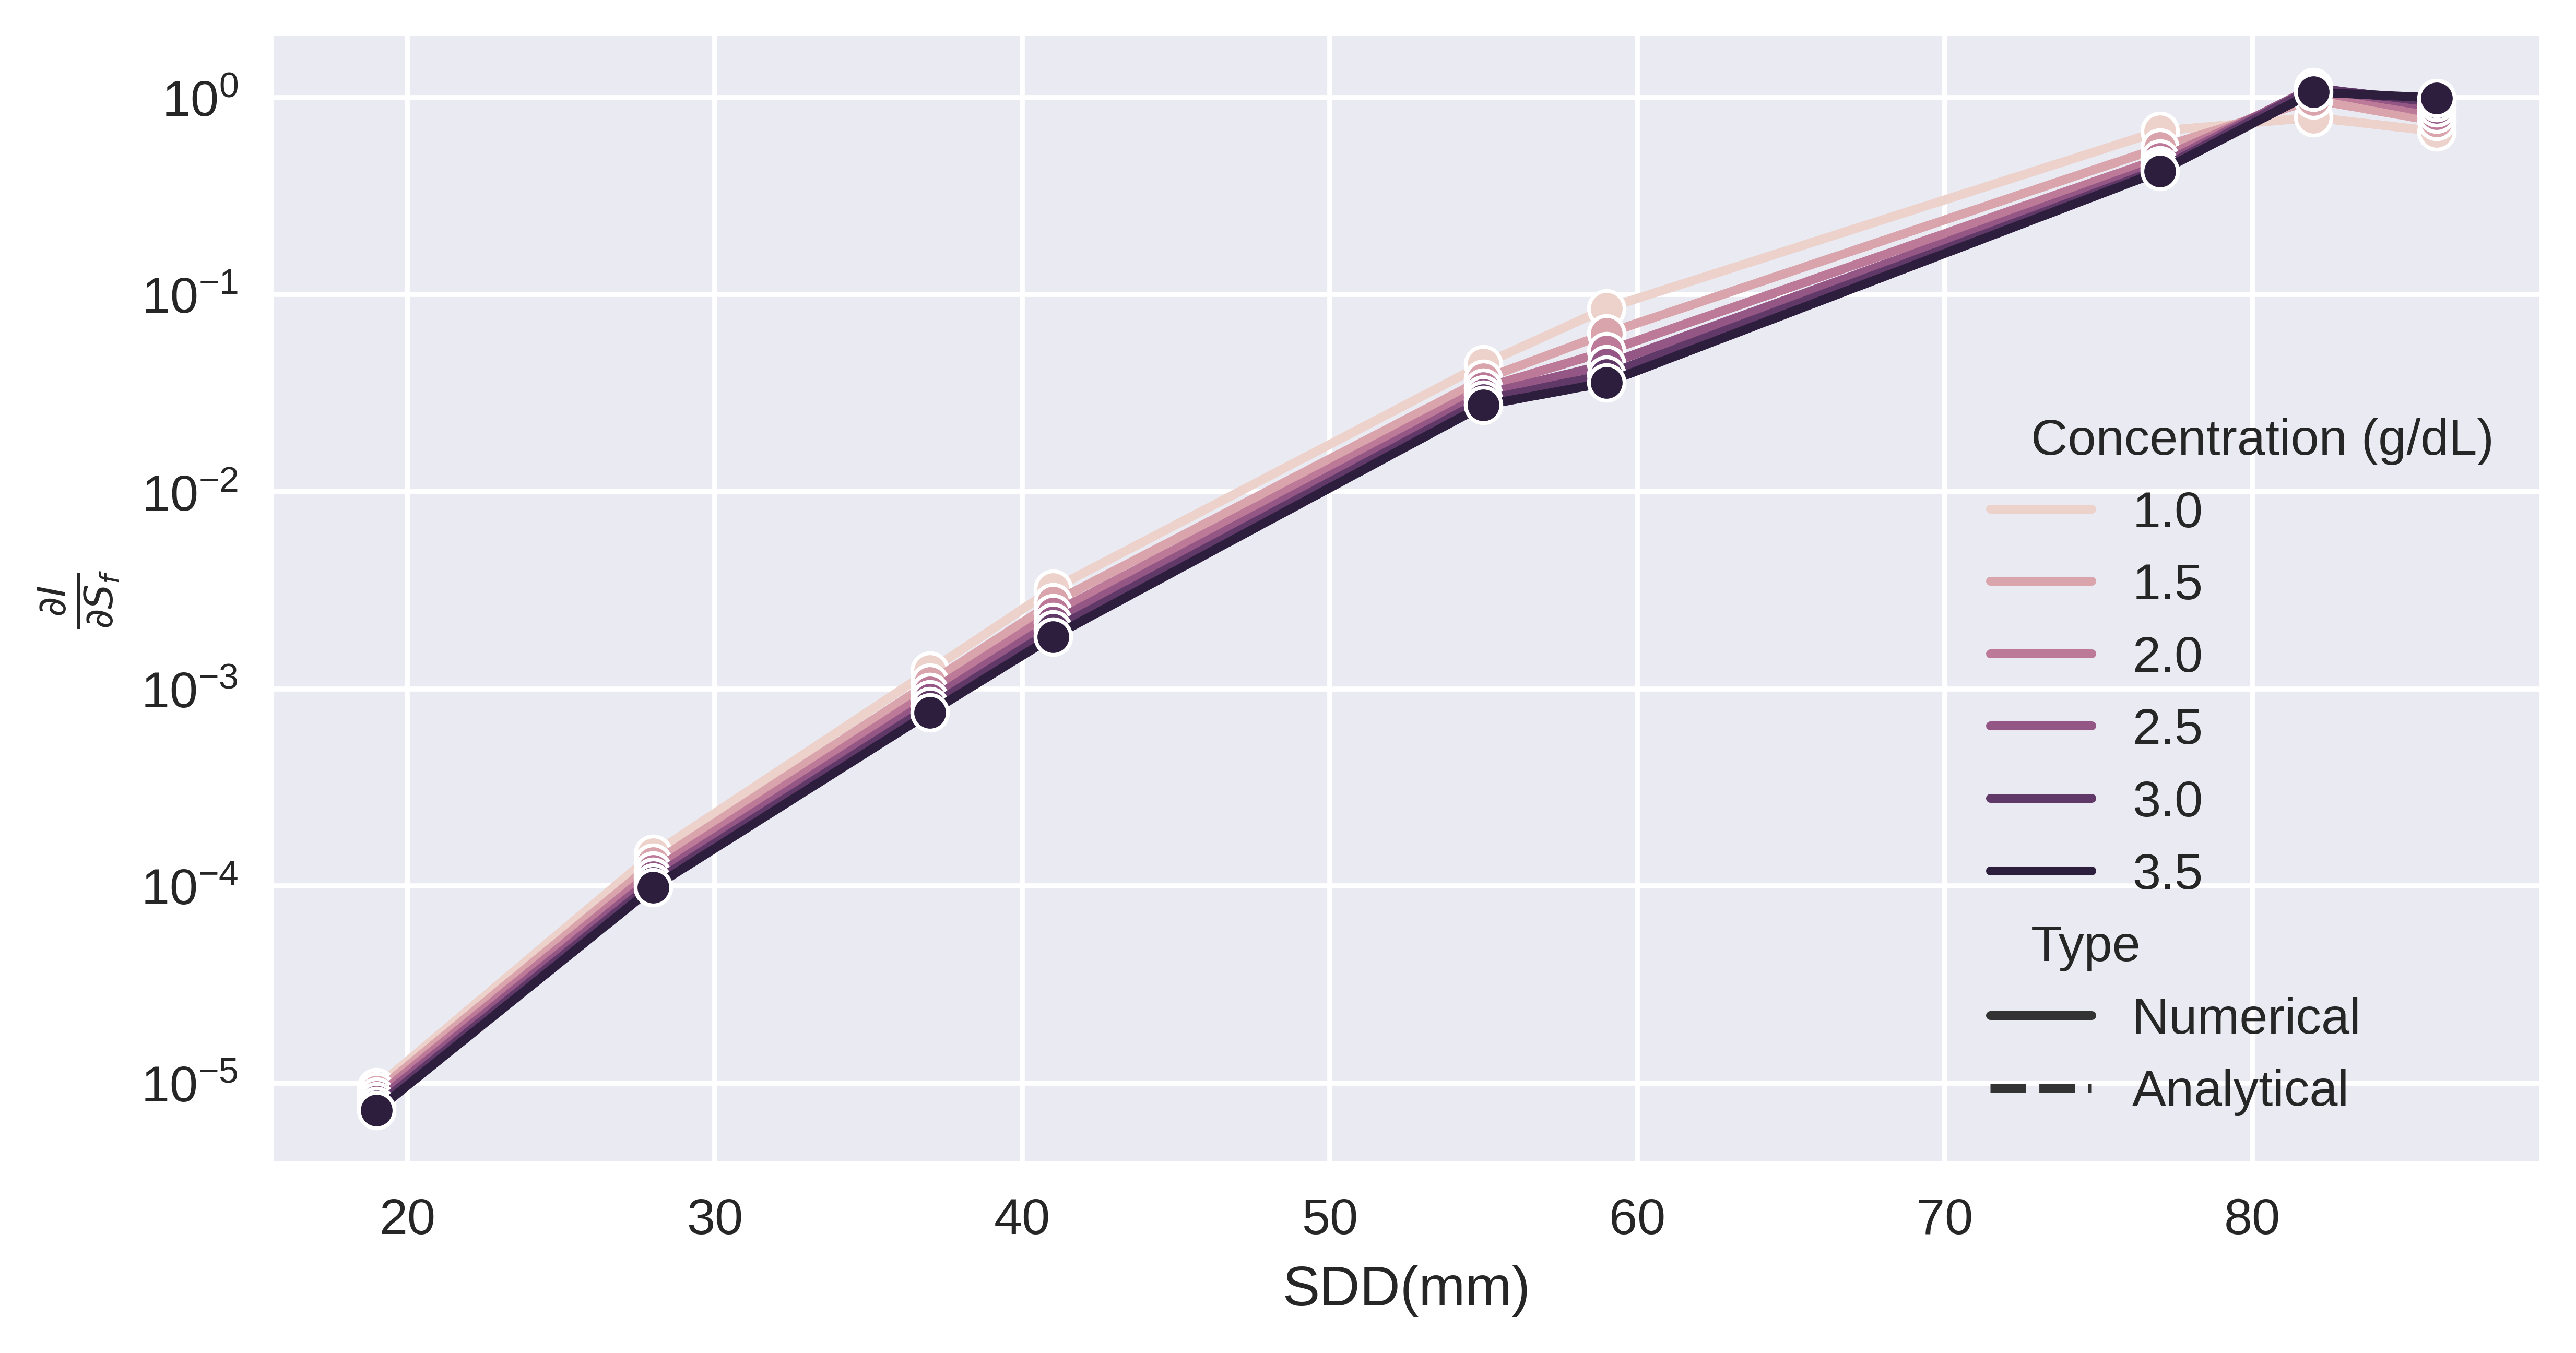

In [6]:
plt.figure(figsize=(8, 4))
plot = sns.lineplot(data=data_table, x='SDD', y='Derivative', hue='Concentration (g/dL)', style='Type', marker='o')
# plot = sns.lineplot(data=data_table[data_table['Type'] == 'Analytical'], x='SDD', y='Derivative', hue='Concentration (g/dL)', marker='o')
# plot = sns.lineplot(data=data_table[data_table['Type'] == 'Numerical'], x='SDD', y='Derivative', hue='Concentration (g/dL)', marker='o')
plt.yscale('log')
plt.xlabel('SDD(mm)')
plt.ylabel(r'$\frac{\partial I}{\partial S_f} $')

## Jacobian For Concentration
From my derivations,
$$
\frac{\delta I}{\delta c} = -\epsilon \times \sum (L_i I_i)
$$

In [17]:
MATERNAL_Hb = 2.
MATERNAL_SAT = 1.0
FETAL_SAT = 0.225
FETAL_Hb = 0.9
DELTA = 0.000001

data_table = pd.DataFrame(columns=['Concentration(g/dL)', 'Derivative', 'SDD', 'Type'])
all_fetal_conc = np.arange(0.5, 4.0, 0.5)
base_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2

modified_mu_map = base_mu_map.copy()

modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
modified_mu_map[4] = get_mu_a(FETAL_SAT, FETAL_Hb, wave_int)


for sdd_index in np.arange(2, 20, 2):
    SDD = all_sdd[sdd_index]
    filtered_photon_data  = (raw_sim_data[raw_sim_data["SDD"] == SDD]).copy()
    for fc in all_fetal_conc:
        dI = calculate_jacobian(jacobian_type, raw_sim_data, sdd_index, base_mu_map, DELTA, 'FS', all_sdd, MATERNAL_Hb, MATERNAL_SAT, fc, FETAL_SAT, wave_int)
        
        # Analytical Expression
        eps = get_mu_a(FETAL_SAT, fc, wave_int)
        modified_mu_map[4] = get_mu_a(FETAL_SAT, fc, wave_int)
        I = generate_intensity_column(filtered_photon_data, modified_mu_map, sdd_index)
        L = filtered_photon_data["L4 ppath"].to_numpy()
        analytical_term =  eps * np.dot(L, I)
        if PLOT_NORMALIZED:
            analytical_term /= np.sum(I) 
        # Adding to Table
        # Adding to Table
        new_row1 = {'Concentration(g/dL)' : fc, 'Derivative': dI, 'SDD': all_sdd[sdd_index], 'Type': 'Numerical'}
        new_row2 = {'Concentration(g/dL)' : fc, 'Derivative': analytical_term, 'SDD': all_sdd[sdd_index], 'Type': 'Analytical'}
        data_table.loc[len(data_table)] = new_row1
        data_table.loc[len(data_table)] = new_row2

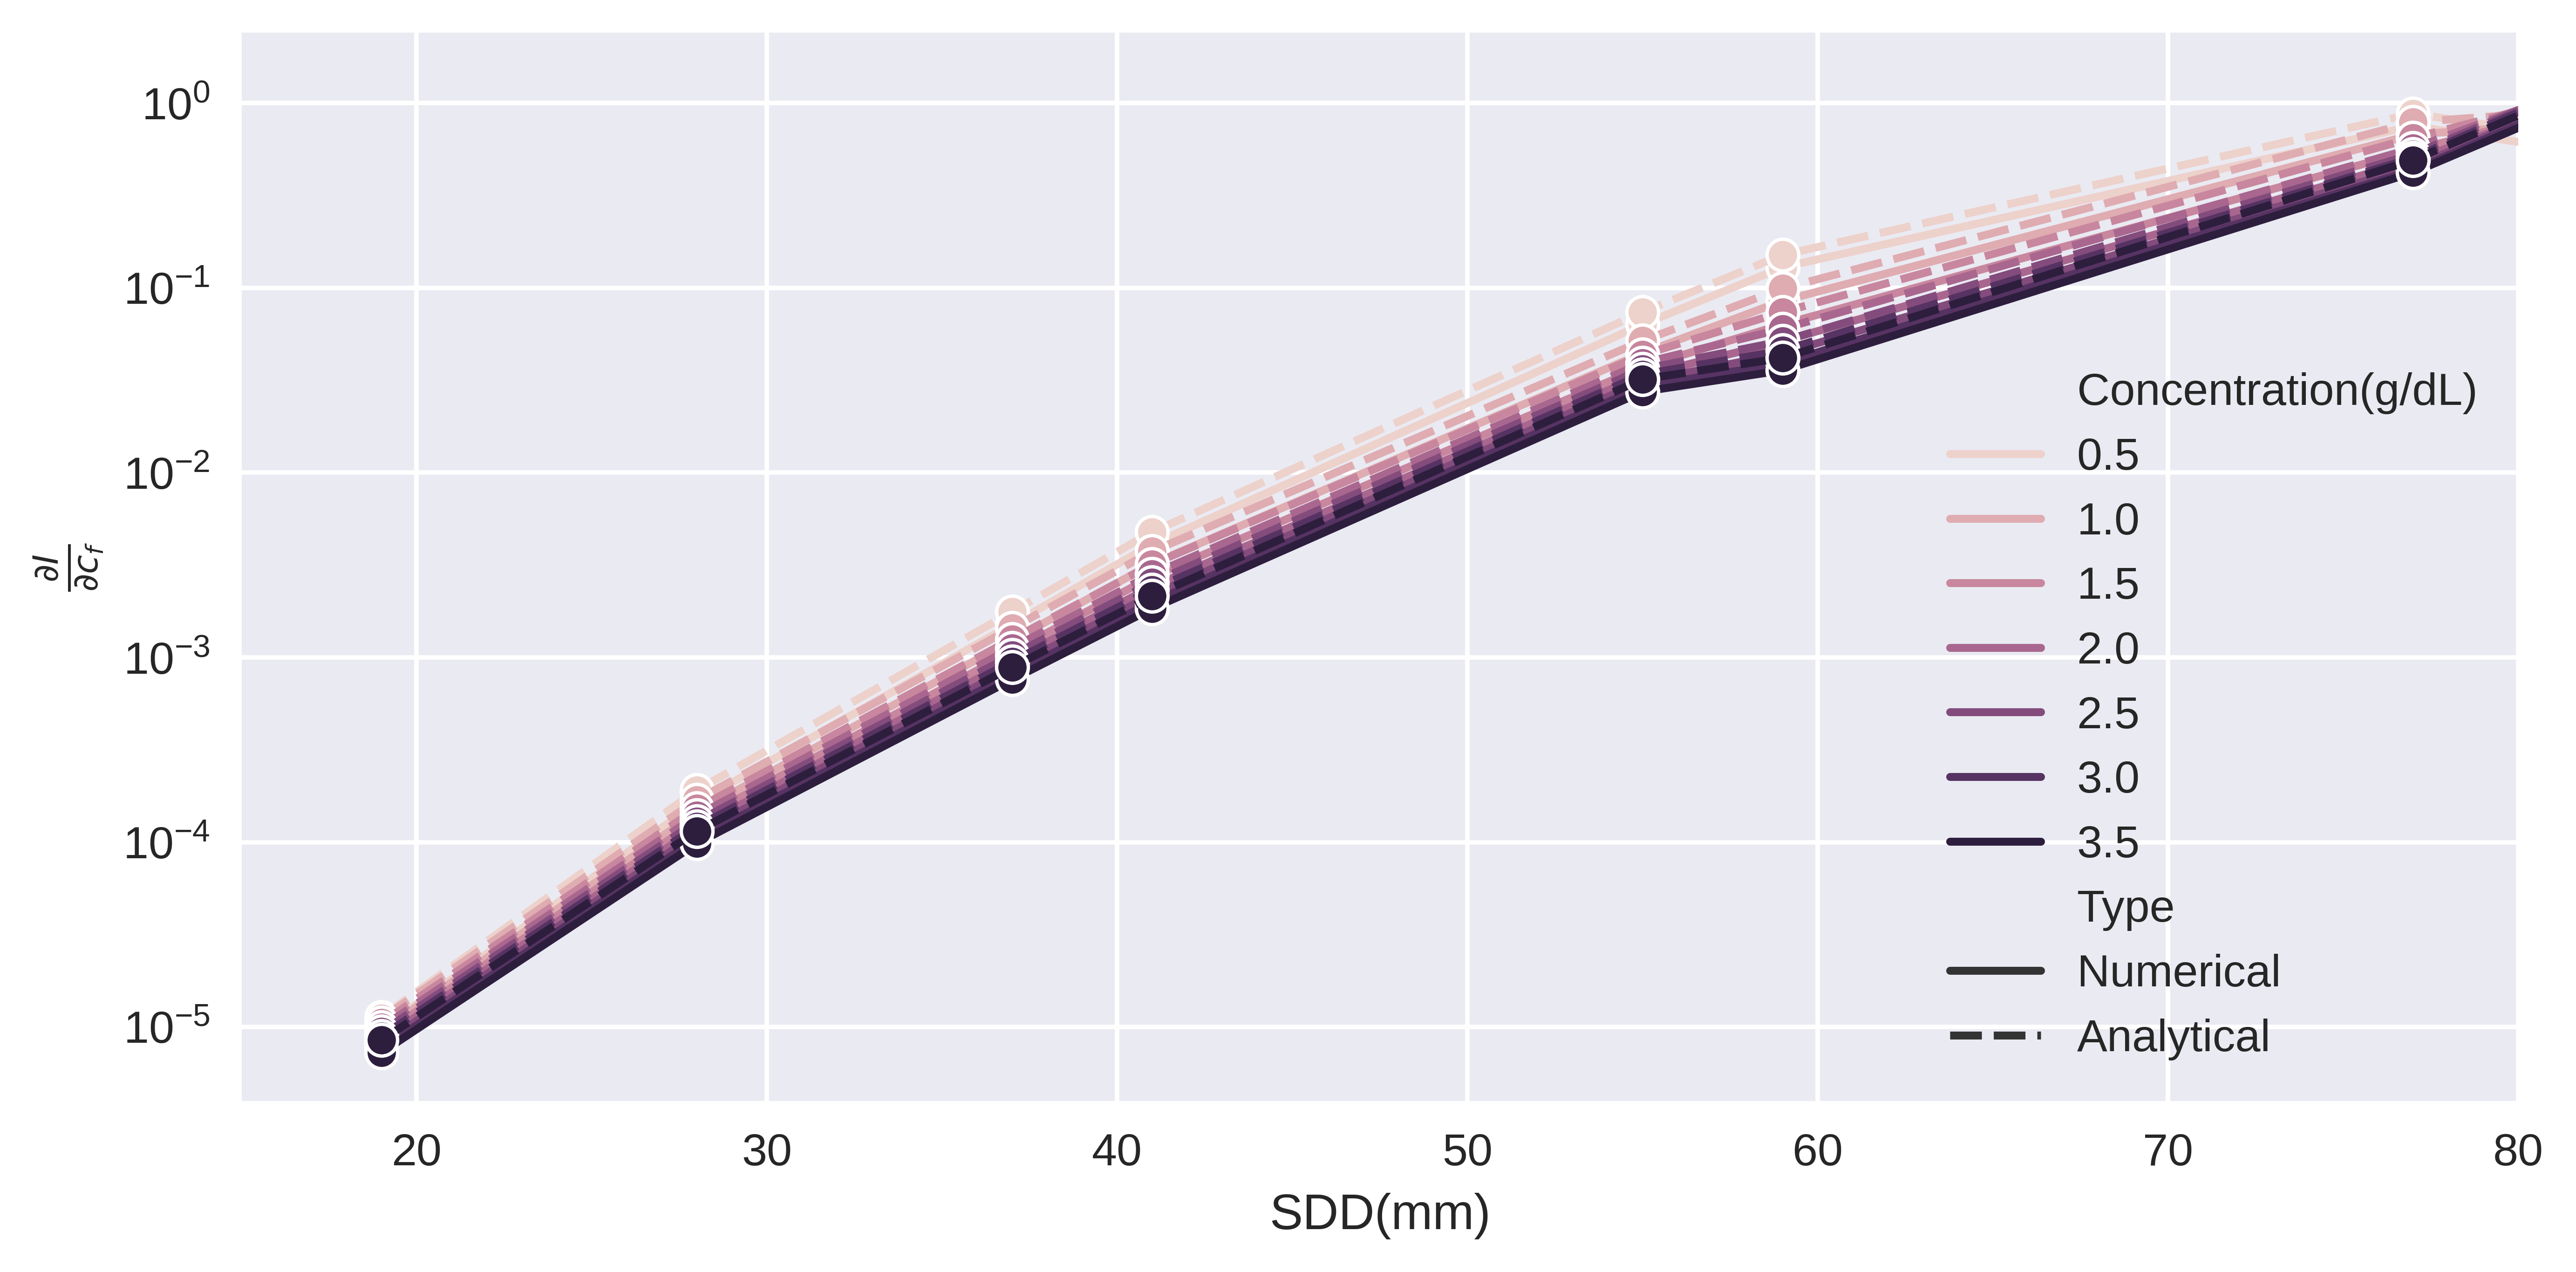

In [18]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=data_table, x='SDD', y='Derivative', hue='Concentration(g/dL)', style='Type', marker='o')
plt.legend()
plt.yscale('log')
plt.xlabel('SDD(mm)')
plt.ylabel(r'$\frac{\partial I}{\partial c_f} $')
plt.xlim([15, 80])   # Avoiding a weird noise artifact
plt.tight_layout()

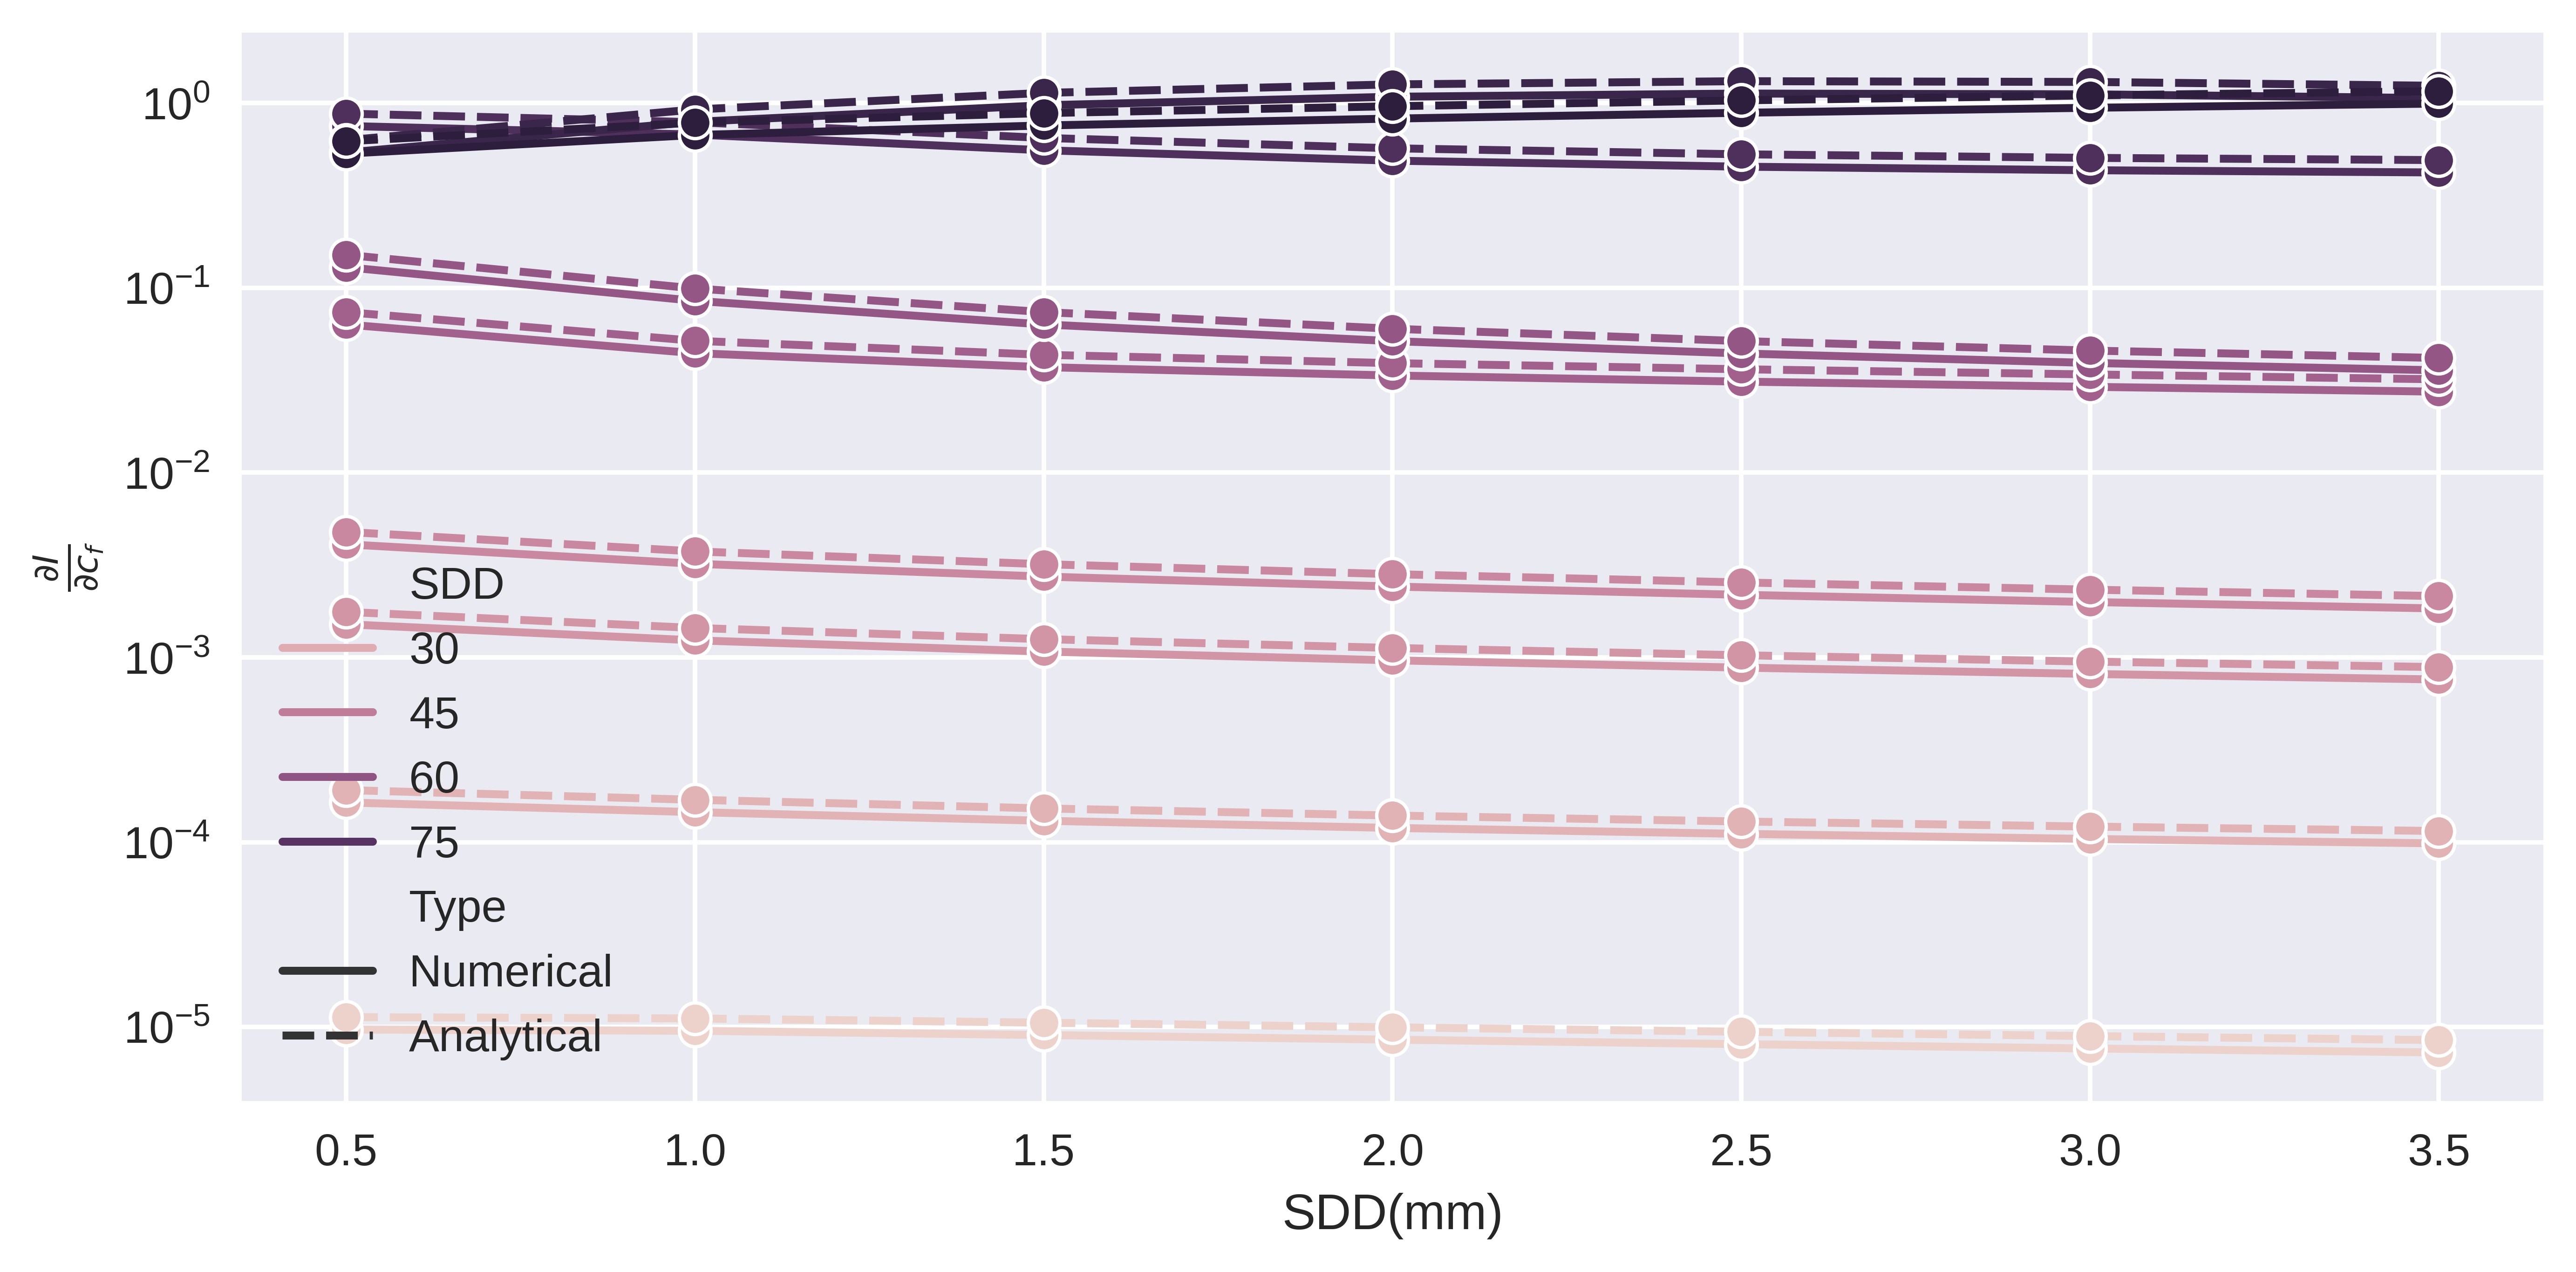

In [9]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=data_table, x='Concentration(g/dL)', y='Derivative', hue='SDD', style='Type', marker='o')
plt.legend()
plt.yscale('log')
plt.xlabel('SDD(mm)')
plt.ylabel(r'$\frac{\partial I}{\partial c_f} $')
plt.tight_layout()

In [15]:
MATERNAL_Hb = 2.
MATERNAL_SAT = 1.0
FETAL_SAT = 0.225
FETAL_Hb = 0.9
DELTA = 0.000001

data_table = pd.DataFrame(columns=['Saturation', 'Derivative', 'SDD', 'Type'])
all_fetal_sat = np.arange(0.10, 0.60, 0.10)
base_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2

modified_mu_map = base_mu_map.copy()

modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
modified_mu_map[4] = get_mu_a(FETAL_SAT, FETAL_Hb, wave_int)


for sdd_index in np.arange(2, 20, 2):
    SDD = all_sdd[sdd_index]
    filtered_photon_data  = (raw_sim_data[raw_sim_data["SDD"] == SDD]).copy()
    for fs in all_fetal_sat:
        fs = round(fs, 2)
        dI = calculate_jacobian(jacobian_type, raw_sim_data, sdd_index, base_mu_map, DELTA, 'FS', all_sdd, MATERNAL_Hb, MATERNAL_SAT, FETAL_Hb, fs, wave_int)
        
        # Analytical Expression
        eps = get_mu_a(fs, FETAL_Hb, wave_int)
        modified_mu_map[4] = get_mu_a(fs, FETAL_Hb, wave_int)
        I = generate_intensity_column(filtered_photon_data, modified_mu_map, sdd_index)
        L = filtered_photon_data["L4 ppath"].to_numpy()
        analytical_term =  eps * np.dot(L, I)
        if PLOT_NORMALIZED:
            analytical_term /= np.sum(I) 
        # Adding to Table
        # Adding to Table
        new_row1 = {'Saturation' : fs, 'Derivative': dI, 'SDD': all_sdd[sdd_index], 'Type': 'Numerical'}
        new_row2 = {'Saturation' : fs, 'Derivative': analytical_term, 'SDD': all_sdd[sdd_index], 'Type': 'Analytical'}
        data_table.loc[len(data_table)] = new_row1
        data_table.loc[len(data_table)] = new_row2

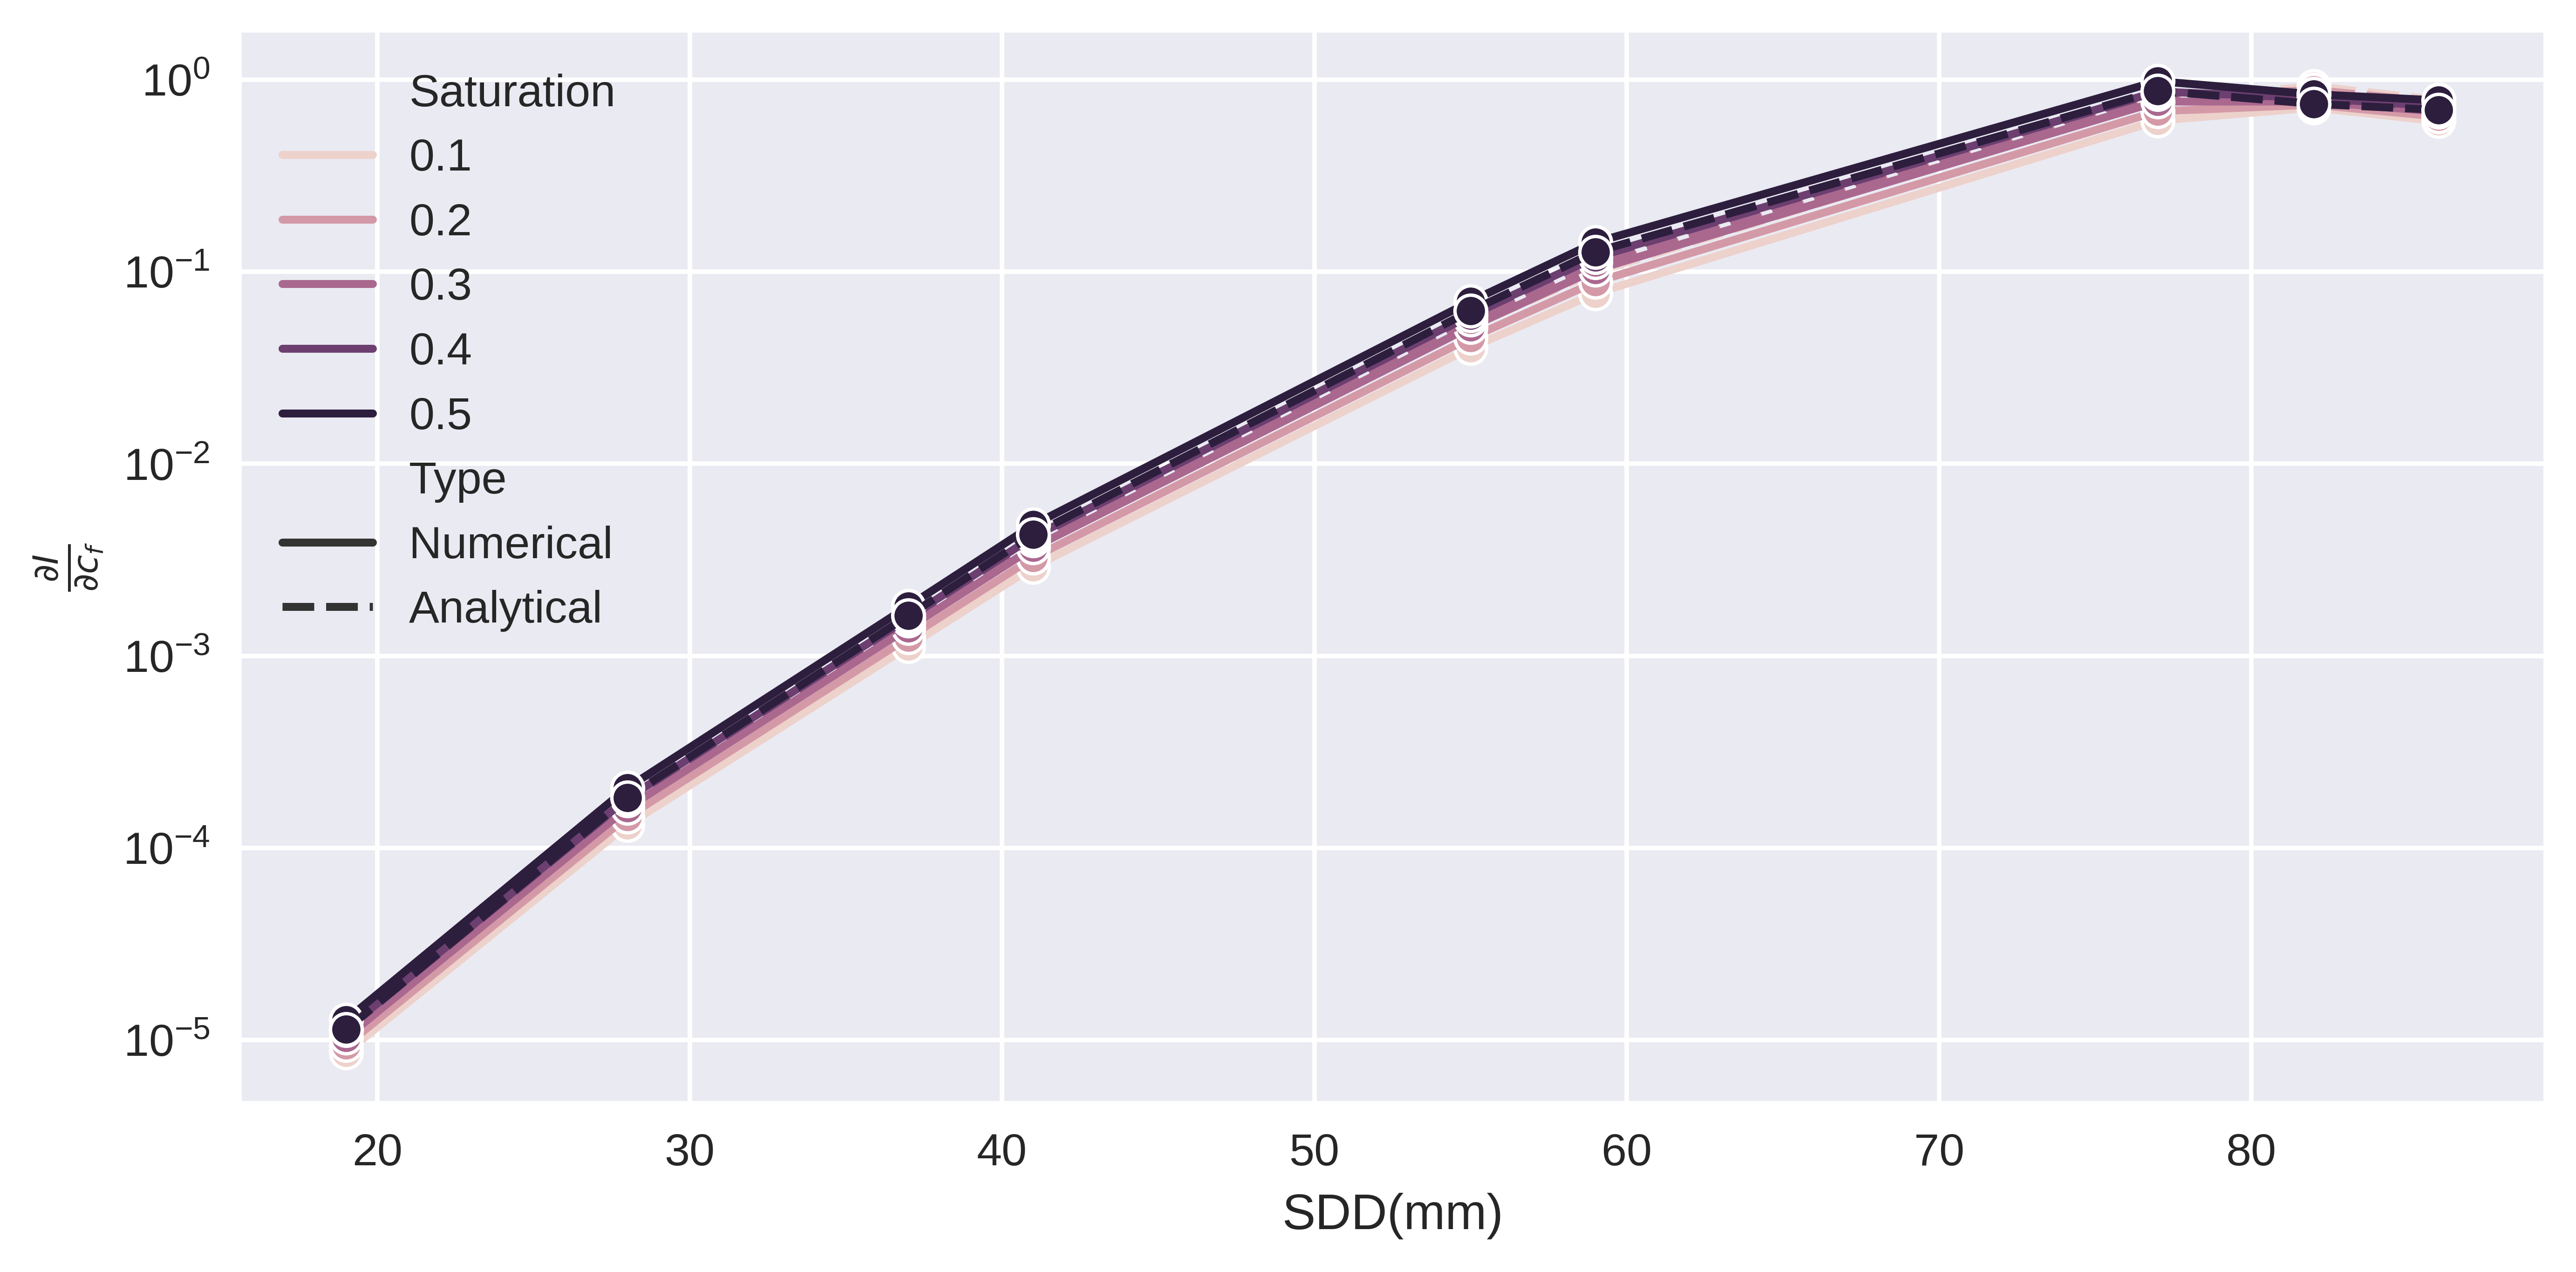

In [16]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=data_table, x='SDD', y='Derivative', hue='Saturation', style='Type', marker='o')
plt.legend()
plt.yscale('log')
plt.xlabel('SDD(mm)')
plt.ylabel(r'$\frac{\partial I}{\partial c_f} $')
plt.tight_layout()